# Coastline extraction using Landsat-8 multispectral imagery and band ratio technique

## Table of Contents
* [Introduction](#1)
* [Necessary imports](#2)
* [Connect to your GIS](#3)
* [Get the data for analysis](#4) 
* [Prepare data for analysis](#6)
    * [Create geometry of aoi](#7)
    * [Filter out the Landsat-8 tiles](#8)
    * [Create mosaic raster from tiles](#9)
* [Preprocessing of the data](#10)
    * [Extract bands from Landsat-8 tiles](#11)
* [Band ratio technique](#12)
* [Postprocessing of results](#13)
    * [Clip out extra area](#13)
    * [Get the data in feature layer](#14)
    * [Coastline extraction](#15)
    * [Get the coastline](#16)
* [Results](#17)
* [Conclusion](#18)
* [Data resources](#19)

## Introduction<a class="anchor" id="1"></a>

Due to anthropogenic activities and natural processes i.e. changes in sea level, sedimentation and wave energy coastlines are changing throughout the world. Coastline is contact line between sea and land, it is an important linear feature on earth's surface with dynamic nature. 

Traditionally, the coastlines were manually digitized which was time-consuming and labour intensive. Remote sensing is a good alternative to extract coastlines using satellite imagery, this way both temporal and spatial aspects can be covered.

Satellite imagery of visible range can be used for interpretation and can be easily obtained. But the imageries covering infrared wavelength is best to extract boundary between land and water. So, the satellites which covers both visible and infrared spectrum are widely accepted for coastline extraction and mapping.

Landsat-8 multispectral imagery is used in the current study as it covers a wavelength ranging from 0.43 to 12.51 micrometers, and hence suitable for coastal and aerosol studies. 

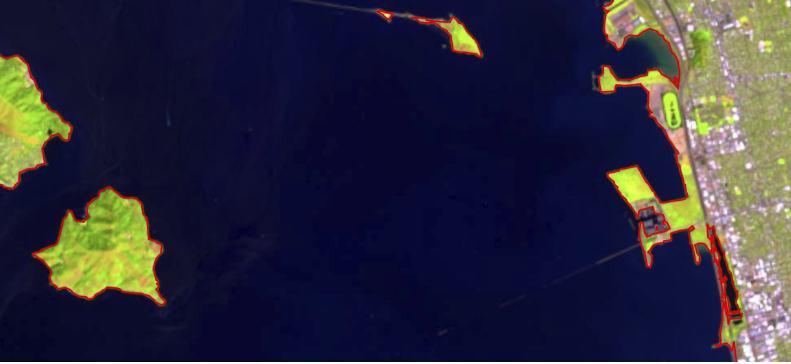

## Neccessary Imports <a class="anchor" id="2"></a>

In [1]:
import os
import glob
from zipfile import *

import arcgis
import arcpy
from arcpy.management import PolygonToLine
from datetime import datetime
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.raster.analytics import convert_raster_to_feature
from arcgis.features.manage_data import overlay_layers
from arcgis.raster.functions import equal_to, greater_than, greater_than_equal, clip, apply, extract_band, stretch

## Connect to your GIS <a class="anchor" id="3"></a>

In [2]:
from arcgis import GIS
gis =  GIS('home')
gis2 = GIS(profile="your_enterprise_portal")

## Get the data for analysis<a class="anchor" id="4"></a>

[Multispectral Landsat](https://www.arcgis.com/home/item.html?id=d9b466d6a9e647ce8d1dd5fe12eb434b) includes Landsat GLS and Landsat 8 imagery for use in visualization and analysis. This layer is time enabled and includes a number band combinations and indices rendered on demand. The Landsat 8 imagery includes eight multispectral bands from the Operational Land Imager (OLI) with 30m spatial resolution and two bands from the Thermal Infrared Sensor (TIRS) of 100m spatial resolution.  It is updated daily with new imagery directly sourced from the Landsat on AWS collection.

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>
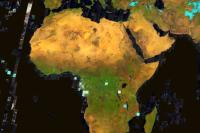

In [3]:
landsat_item = gis.content.get('d9b466d6a9e647ce8d1dd5fe12eb434b')
landsat = landsat_item.layers[0]
landsat_item

The buffer feature of 20 km was created from USA boundaries. This feature layer geometry will be used to get the Landsat-8 tiles of coastal areas.

<Item title:"usa_coast_polygon" type:Feature Layer Collection owner:api_data_owner>
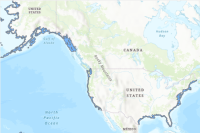

In [4]:
aoi = gis.content.get('6ee0006608704d0389881e0bcf936778')
aoi

## Prepare data for analysis<a class="anchor" id="6"></a>

A map widget was created, which will define the extent of area of interest for the analysis.

In [5]:
m = gis.map('USA', 4)
m.add_layer(aoi)
m

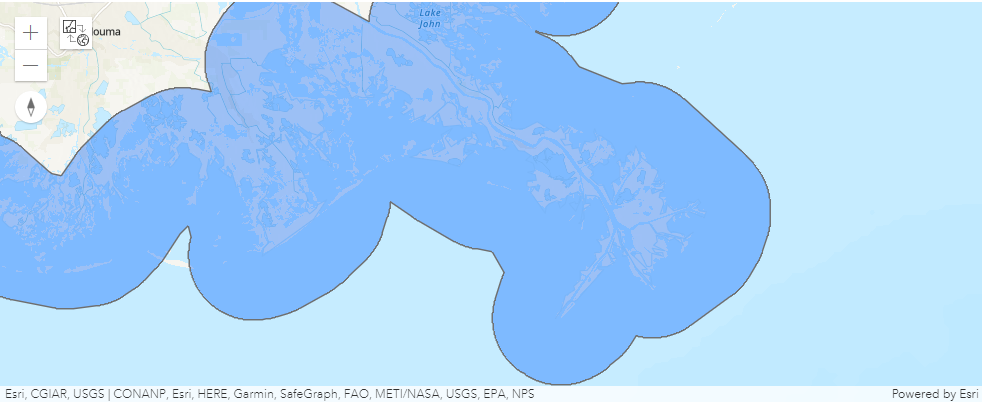

In [6]:
m.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': -10124000.92647267,
 'ymin': 3341135.188124092,
 'xmax': -9823144.78314236,
 'ymax': 3463434.4333803146}

Multispectral imagery layers consist of data for whole world. First step, is to filter out the cloud free data for the study area which will be used in the analysis.

### Create geometry of aoi<a class="anchor" id="7"></a>

The aoi has four polygons representing: Islands, East coast, West coast and Alaska.

In [7]:
dfm = aoi.layers[0].query(out_fields="OBJECTID, type, code").sdf
dfm

,OBJECTID,type,code,SHAPE
0,1,islands,1,"{""rings"": [[[-17328342.0256, 2126164.6003], [-..."
1,2,eastern_coast,1,"{""rings"": [[[-10796721.2644, 2984284.5892], [-..."
2,3,alaska,1,"{""rings"": [[[-17408919.7589, 11517244.7315], [..."
3,4,western_coast,1,"{""rings"": [[[-13019578.4789, 3857089.5857], [-..."


In the current analysis  the area of interest is situated at East coast. The geometry of aoi was created for filtering out the landsat-8 tiles for the study area. `objectid=2` was used as it represents the east coast.

In [8]:
aoi_layer = aoi.layers[0]

## use the correct objectid by refering to the above dataframe for your area of interest. 
aoi_feature = aoi_layer.query(where="objectid=2")
aoi_geom = aoi_feature.features[0].geometry
aoi_geom['spatialReference'] = {'wkid':3857}

### Filter out the Landsat-8 tiles<a class="anchor" id="8"></a>

The landsat-8 tiles were filtered out on the basis of date of acquisition and cloud cover. The order of tiles is on the basis of cloud cover from low to high.

In [9]:
import pandas as pd
from datetime import datetime
selected = landsat.filter_by(where="(Category = 1) and (CloudCover<0.03)",
                             time=[datetime(2016, 1, 1), datetime(2019, 12, 31)],
                             geometry=arcgis.geometry.filters.intersects(aoi_geom))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="CloudCover").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df

,OBJECTID,AcquisitionDate,GroupName,CloudCover,DayOfYear,SHAPE
0,1981400,2017-10-27 15:34:47,LC08_L1GT_013034_20171027_20200902_02_T2_MTL,0.0000,34,"{""rings"": [[[-8124157.0645, 4595882.337700002]..."
1,708456,2019-08-30 15:34:41,LC08_L1GT_013034_20190830_20200826_02_T2_MTL,0.0000,34,"{""rings"": [[[-8120029.161, 4595955.806000002],..."
2,2014524,2016-09-30 16:26:09,LC08_L1TP_021039_20160930_20200906_02_T1_MTL,0.0000,39,"{""rings"": [[[-9731664.0351, 3627576.194600001]..."
3,2001165,2017-03-04 16:07:36,LC08_L1TP_018040_20170304_20200905_02_T1_MTL,0.0000,40,"{""rings"": [[[-9261778.5607, 3442875.9834999964..."
4,2021672,2016-04-05 16:38:19,LC08_L1TP_023040_20160405_20200907_02_T1_MTL,0.0000,40,"{""rings"": [[[-10121801.5565, 3442899.711800001..."
...,...,...,...,...,...,...
771,2019440,2017-04-08 16:37:48,LC08_L1TP_023039_20170408_20200904_02_T1_MTL,0.0294,39,"{""rings"": [[[-10078992.0945, 3627741.781099997..."
772,1626973,2018-08-22 16:57:07,LC08_L1TP_026041_20180822_20200831_02_T1_MTL,0.0295,41,"{""rings"": [[[-10677865.1634, 3260354.100499999..."
773,2912525,2017-04-09 15:40:58,LC08_L1TP_014036_20170409_20200904_02_T1_MTL,0.0297,36,"{""rings"": [[[-8393943.8222, 4199194.052900001]..."
774,1978579,2017-06-14 15:26:01,LC08_L1TP_012029_20170614_20200903_02_T1_MTL,0.0299,29,"{""rings"": [[[-7672952.0537, 5657896.1329], [-7..."


In [10]:
## Create a list of tiles 
oid = df["OBJECTID"].tolist()

### Create mosaic raster from tiles<a class="anchor" id="9"></a>

After creating a list of landsat-8 tiles, next step was to create a mosaic raster for the study area. `mosaic_by` was used to lock all the tiles of landsat-8 list.

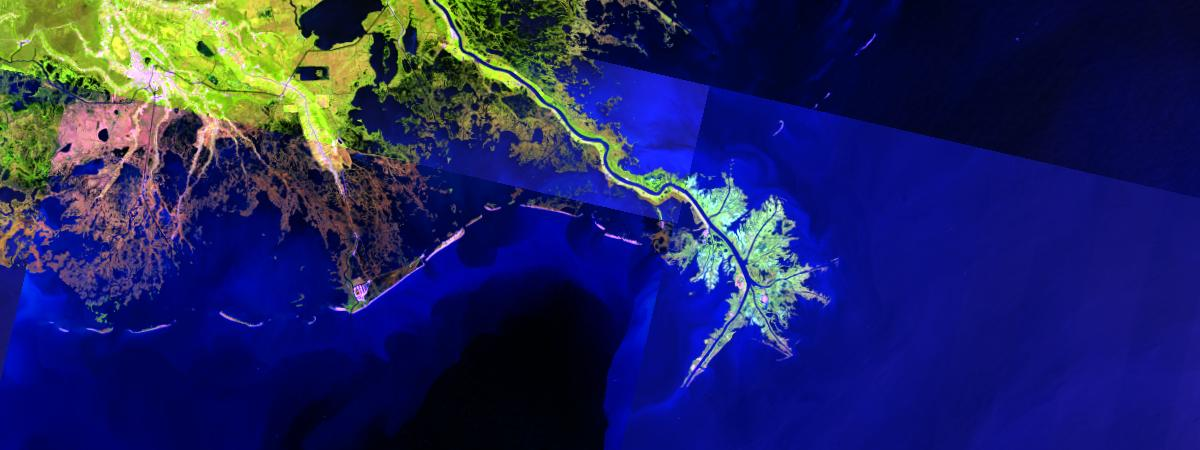

In [11]:
landsat.mosaic_by(method='lock_rasters', lock_rasters=oid)
landsat.extent = m.extent
landsat

## Preprocessing of the data<a class="anchor" id="10"></a>

### Extract bands from Landsat-8 tiles<a class="anchor" id="11"></a>

From the mosaic raster, 3 single band raster were created for NIR, Red and Blue band using [extract_band](https://desktop.arcgis.com/en/arcmap/latest/manage-data/raster-and-images/extract-bands-function.htm) function.

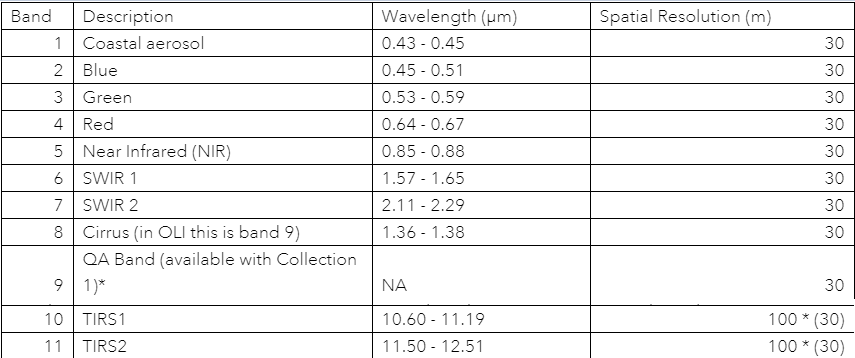 

#### <Center>Landsat-8 band spectrum table<Center> ####

Landsat-8 fifth band covers 0.85 - 0.88 micrometers of EMR spectrum. NIR band is best for delineating land and water interface. Due to high absorption of water in NIR spectrum the reflectance of water is around zero whereas vegetation and land has high reflectance value. In NIR imagery the water appears black and land & vegetation appears bright grey to white which makes it easier to delineate land and water boundary. 

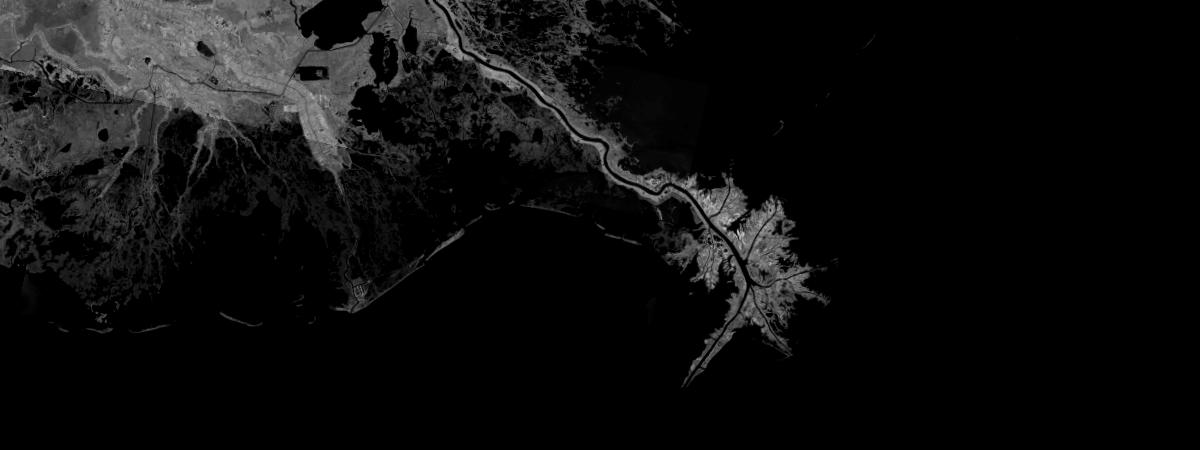

In [12]:
nir1 = extract_band(landsat, [5])
nir1

Second band of landsat-8 represents blue spectrum and covers 0.45 - 0.51 micrometer. Water has high reflectance in blue spectrum.

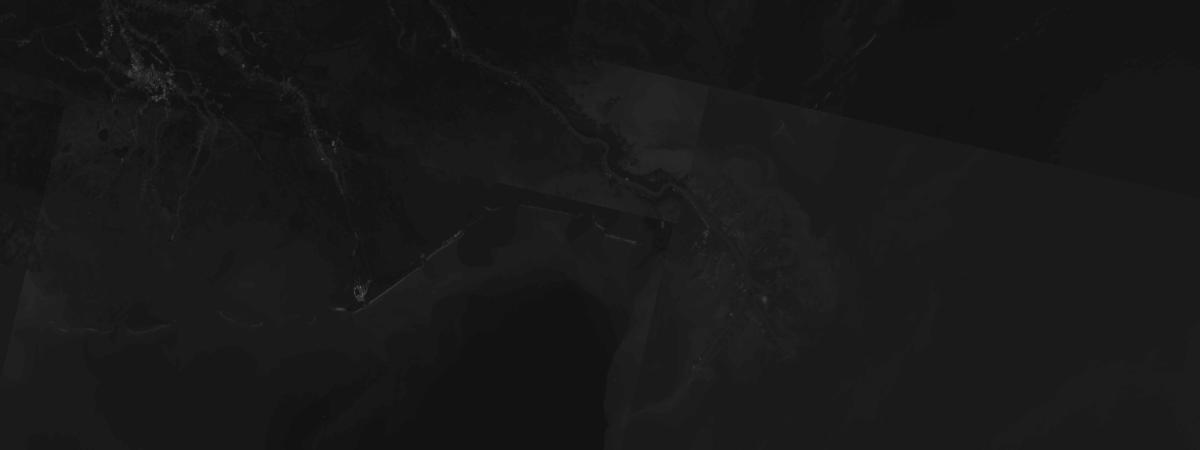

In [13]:
blue1 = extract_band(landsat, [2])
blue1

Fourth band represents red spectrum and covers 0.64 - 0.67 micrometer wavelength of EMR spectrum. Red spectrum is highly absorbed by vegetation and this is useful to delineate between soil and vegetation.

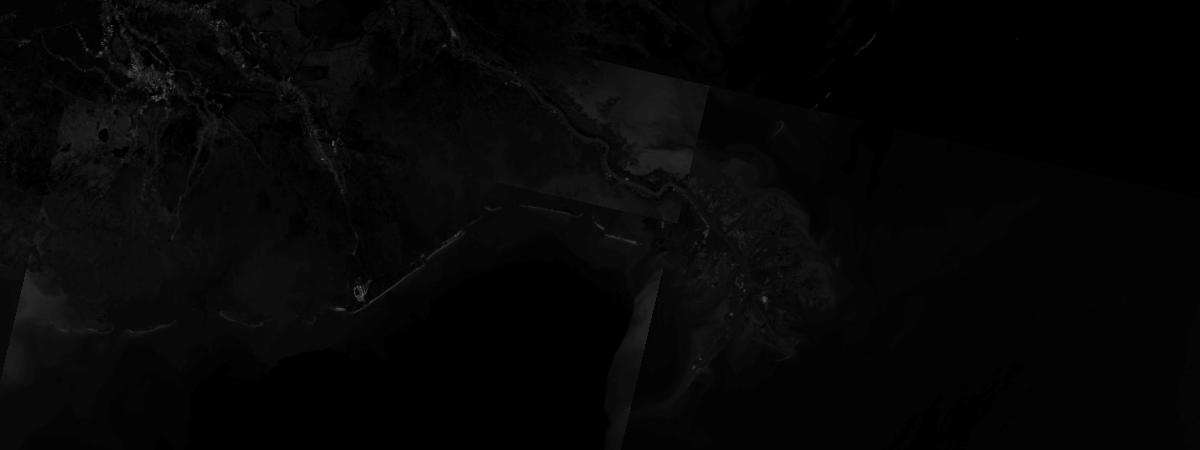

In [14]:
red1 = extract_band(landsat, [4])
red1

### Band ratio technique<a class="anchor" id="12"></a>

A recent remote sensing technique to extract coastline is `Band Ratio`. In this technique the DN values of bands are divided to create a binary raster. NIR, Red and Blue bands were used for creating the binary raster. NIR band is selected as it is able to delineate water-land boundary, Red band is important for vegetation and water content and Blue band has high reflectance in water bodies. In the current study the following band ratio formula was used:

                                     Blue>NIR & Blue>Red
The output of this formula is a binary raster which has 0 and 1 pixel value. 1 represents water (white pixels) and 0 represents land (black pixels) i.e. bare surface, vegetation etc.

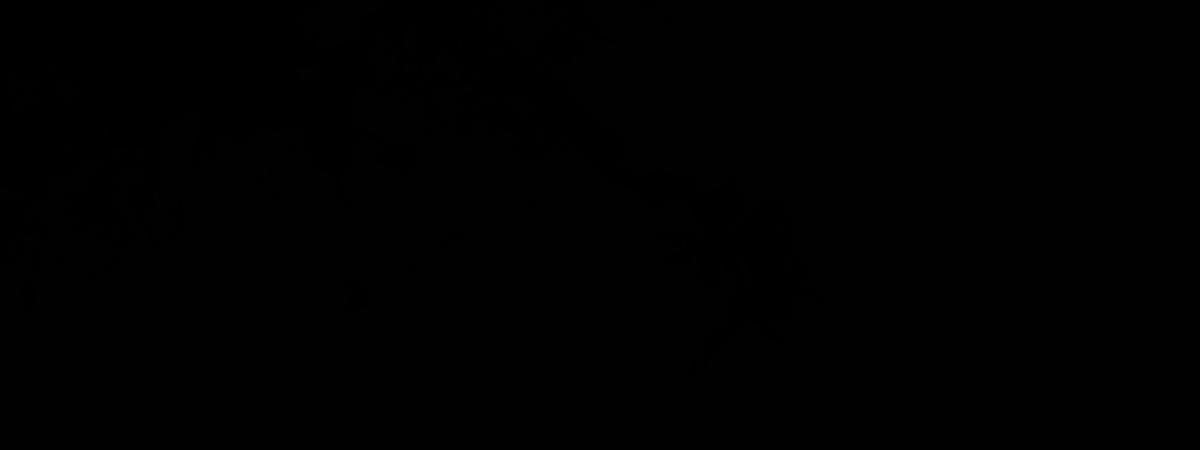

In [15]:
binary1 = arcgis.raster.functions.raster_calculator([nir1, blue1, red1],  
                                                    ['nir', 'blue', 'red'],
                                                    "(blue>nir)&(blue>red)", 
                                                    extent_type='FirstOf', 
                                                    cellsize_type='FirstOf')
binary1

 For vizualisation, [stretch](https://desktop.arcgis.com/en/arcmap/latest/manage-data/raster-and-images/stretch-function.htm#:~:text=Stretching%20improves%20the%20appearance%20of,results%20in%20the%20raster%20display.) raster function was used to stretch function the histogram. After applying stretch the pixel values were changed to 0 and 255 where 0 represents land and 255 represents water.

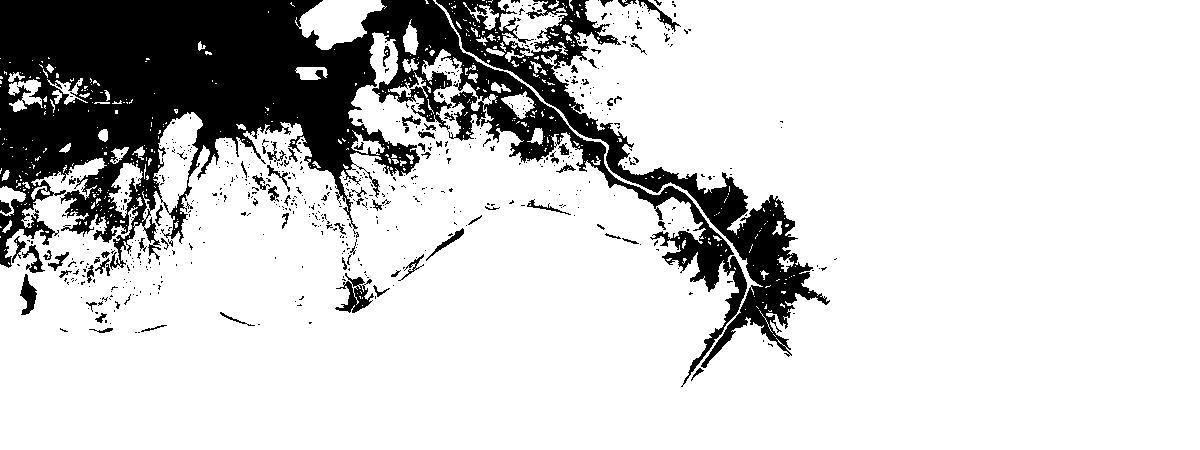

In [16]:
dra1 = arcgis.raster.functions.stretch(binary1, 
                                      stretch_type='MinMax', 
                                      dra=True)
dra1

## Postprocessing of results<a class="anchor" id="13"></a>
### Clip out extra area<a class="anchor" id="13"></a>

The stretched binary raster was clipped out using aoi geometry to clip out the extra area and to minimize the processing time. [Clip](https://developers.arcgis.com/python/api-reference/arcgis.raster.functions.html#clip) raster function was used.

In [17]:
clip_diff1 = clip(dra1, aoi_geom)

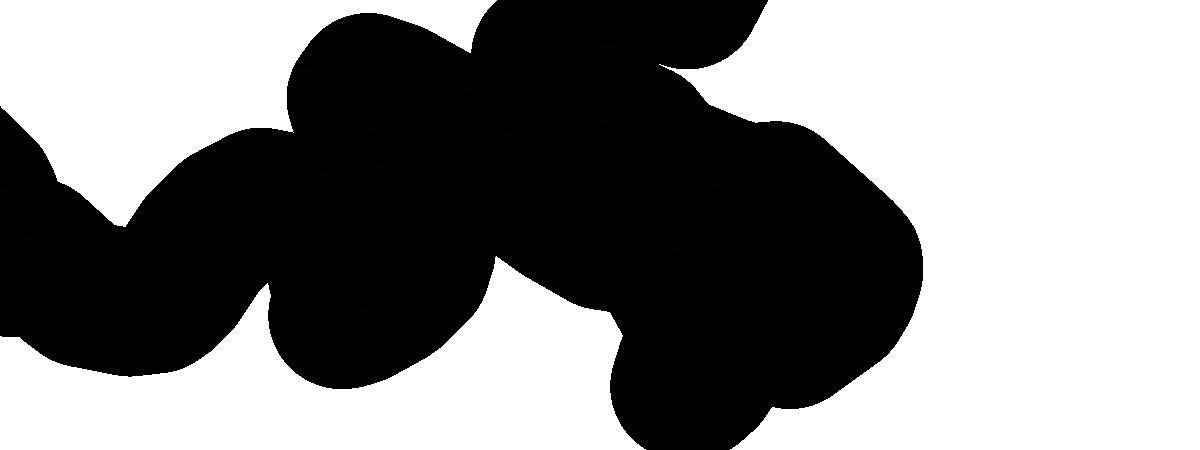

In [18]:
water_ras = greater_than([clip_diff1, 0], extent_type='FirstOf', cellsize_type='FirstOf')
water_raster = water_ras.save('water_ras'+str(datetime.now().microsecond), gis=gis2)
water_ras 

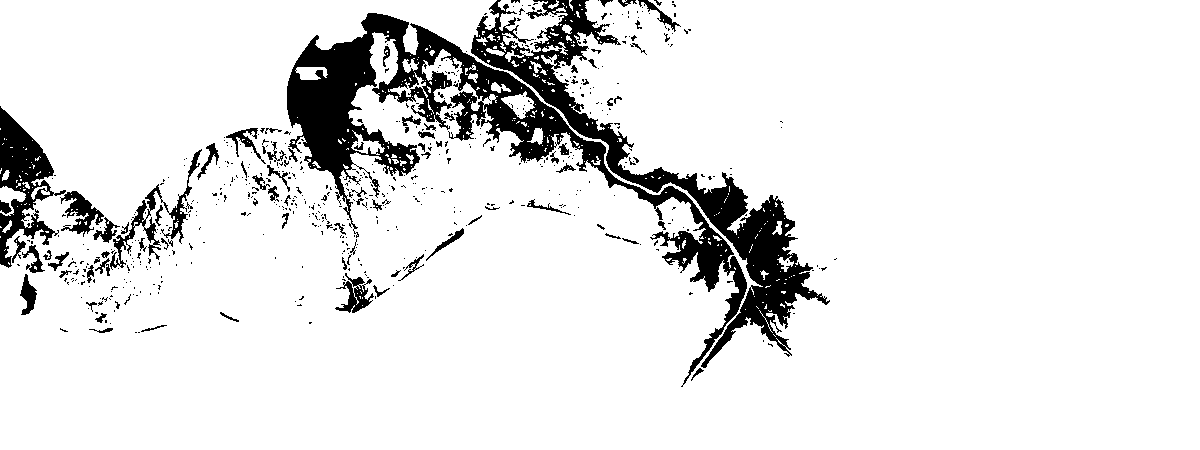

In [19]:
dra2 = arcgis.raster.functions.stretch(water_ras, 
                                      stretch_type='MinMax', 
                                      dra=True)
dra2_ras = dra2.save("dra_raster"+str(datetime.now().microsecond), gis=gis2)
dra2

### Get the data in feature layer<a class="anchor" id="14"></a>

The clipped binary raster was converted to polygon for coastline extraction. [convert_raster_to_feature](https://developers.arcgis.com/python/api-reference/arcgis.raster.analytics.html?highlight=convert_raster_to_feature#arcgis.raster.analytics.convert_raster_to_feature) function was used for conversion.

In [20]:
b2_poly = convert_raster_to_feature(dra2_ras.layers[0], 
                                    field='Value', 
                                    output_type='Polygon', 
                                    simplify=True, 
                                    output_name='coastline_poly'+str(datetime.now().microsecond), 
                                    gis=gis2)

### Coastline extraction<a class="anchor" id="15"></a>

#### Filter out the water polygons

The feature layer was converted to dataframe using `query` and the polygons were ordered on the basis on `Shape_Area` column.

In [21]:
## Create dataframe from feature layer and get water polygons
dfm1 = b2_poly.layers[0].query('gridcode=255').sdf 

## Convert dataframe to feature layer
water_poly = gis2.content.import_data(dfm1, title='coast_poly_full'+str(datetime.now().microsecond))
dfm1

,id,objectid,gridcode,SHAPE
0,1,1,255,"{""rings"": [[[-10003378.34165575, 3471918.92970..."
1,2,2,255,"{""rings"": [[[-9993388.342924597, 3471888.92970..."
2,3,3,255,"{""rings"": [[[-9990868.343244672, 3471918.92970..."
3,5,5,255,"{""rings"": [[[-9972718.345549935, 3471918.92970..."
4,6,6,255,"{""rings"": [[[-9970468.345835714, 3471918.92970..."
...,...,...,...,...
28406,53800,53800,255,"{""rings"": [[[-9952228.348152416, 3367398.94297..."
28407,53801,53801,255,"{""rings"": [[[-9953518.34798857, 3367368.942979..."
28408,53802,53802,255,"{""rings"": [[[-9953668.347969517, 3367128.94300..."
28409,53803,53803,255,"{""rings"": [[[-9953818.347950466, 3367008.94302..."


#### Extract the coastline polygon

The polygon with largest area represents the coastline.The polygon with highest value in `Shape_Area`column was extracted by referring the `df`. The new dataframe was converted to feature layer using `import_data` function.

In [22]:
## Get the polygon with largest area as it will represent the coastline
df = water_poly.layers[0].query().sdf
dfm5 = df[df['SHAPE__Area']==df['SHAPE__Area'].max()]
coast_poly = gis2.content.import_data(dfm5, title='coast_poly'+str(datetime.now().microsecond))

#### Convert coastline polygons to line

The coastline polygon was converted to line using [PolygonToLine](https://desktop.arcgis.com/en/arcmap/10.3/tools/data-management-toolbox/polygon-to-line.htm) arcpy function.

In [23]:
dc_df = pd.DataFrame.spatial.from_layer(coast_poly.layers[0])
display(dc_df.head())

,id,SHAPE__Length,objectid,SHAPE__Area,gridcode,SHAPE
0,53818,2.271016e+07,1,1.415751e+10,255,"{""rings"": [[[-10126444.9027, 3401549.207200005..."


In [24]:
# Create empty dataframe
df = pd.DataFrame()

# Create polyline
df['SHAPE'] = dc_df.SHAPE.geom.boundary()
coast_polyline = df.spatial.to_featurelayer('coastline_polyline'+str(datetime.now().microsecond))

#### Remove noise

A mask was created using the clipped raster, it represents the extent of raster. The mask will be used to remove the extra lines.

In [25]:
#Create a mask
mask = greater_than_equal([clip_diff1, -1], extent_type='FirstOf', cellsize_type='FirstOf')
mask_ras = mask.save('mask'+str(datetime.now().microsecond), gis=gis2)

# Create a mask to remove noise which covers whole extent of clipped raster
aoi2 = convert_raster_to_feature(mask_ras.layers[0], 
                                field='Value', 
                                output_type='Polygon', 
                                simplify=True, 
                                output_name='aoi2'+str(datetime.now().microsecond), 
                                gis=gis2)

The coastline layer which we got in the previous step has some extra lines representing the boundary of aoi layer. To remove the extra lines a negative buffer of 10 meter was created using `create_buffer` function.

In [26]:
### Create neg_buffer to remove the noise
neg_buffer = arcgis.create_buffers(aoi2, 
                                   distances=[-10],
                                   units='Meters', 
                                   output_name='aoi_neg_buf'+str(datetime.now().microsecond), 
                                   gis=gis2)

Extra lines were masked out using the negative buffer boundary.

In [27]:
coastline_final = overlay_layers(coast_polyline.layers[0], neg_buffer.layers[0], output_name='extracted_coastline'+str(datetime.now().microsecond))

## Extracted Coastlines<a class="anchor" id="17"></a>

In [28]:
m9= gis2.map('USA', 4)
m9

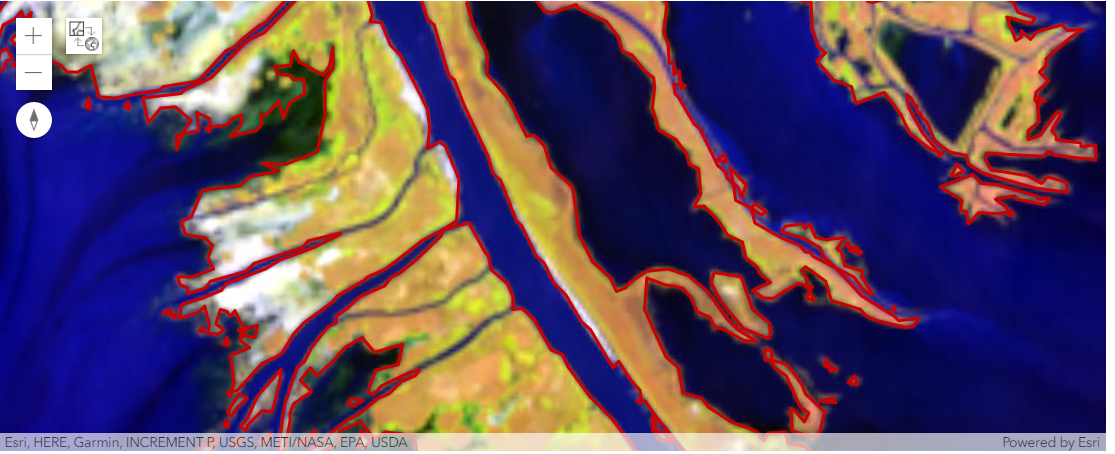

In [29]:
m9.add_layer(landsat)
m9.zoom_to_layer(coastline_final)

In [30]:
## Create dataframe for visualization
dfm_1= coastline_final.layers[0].query(out_fields="*").sdf

## add the dataframe to map widget
dfm_1.spatial.plot(map_widget=m9,
                renderer_type='s', 
                pallete='spring',
                alpha=1
                )

True

Coastline for whole USA were extracted with the above workflow using Landsat-8 imagery. To see the results, click [here](https://arcg.is/SGS5X)

## Conclusion<a class="anchor" id="18"></a>

Band Ratio technique is a efficient method, which gives highly accurate results with less processing time and it is able to cover both temporal and spatial aspects of coastline changes. Band Ratio technique is a easy to calculate method which gives highly accurate results with less processing time. The workflow can be applied on any area using multispectral imagery i.e. Landsat-8, Sentinel-2, etc.

## Literature resources<a class="anchor" id="19">

|Literature | Source | Author |
| -| - |-| 
|Research Paper|                       Shoreline Change Mapping Using Remote Sensing and GIS     | Ali Kourosh Niya, Ali Asghar Alesheikh, Mohsen Soltanpor, Mir Masoud Kheirkhahzarkesh
| Research Paper|                   Shoreline change assessment using remote sensing and GIS techniques: a case study of the Medjerda delta coast, Tunisia           | Mourad Louati & Hanen Saidi & Fouad Zargouni